# **AIN 214 - PA4 - FALL 2024**




**Student Number** : 2220765009

**Name Surname**   : Arda Agacdelen


BELOW MD CELLS CONTAIN THE QUESTIONS YOU ARE ASKED TO IMPLEMENT WITHIN THE CONTEXT OF THIS HW. PLEASE FILL IN THE CELLS FOR THE ANSWERS RIGHT BELOW THE MD CELL OF THE QUESTION. YOU CAN ADD AS MANY CELLS AS YOU WANT, BE IT CODE OR MD, SO LONG AS YOU PROVIDE UNDERSTANDABLE AND TRACEABLE REPORTING. PLEASE ADD COMMENTS ON YOUR CODES. ALSO, FILL IN MD CELLS WHERE YOU ARE ASKED TO COMMENT ON YOUR RESULTS OR EXPLAIN YOUR REASONING. ALSO, PLEASE DO NOT HESITATE TO USE THEM FOR YOUR OWN REPORTING PURPOSES. PLEASE KEEP IN MIND THAT, REPORTING IS A KEY STEP IN DATA SCIENCE.

**Deadline: 13.12.2024 (23:59:59)**

**Submission:** Submit your Jupyter Notebooks via https://submit.cs.hacettepe.edu.tr/

<font color='red'> **!!! PLEASE RUN YOUR CODE.   THE OUTPUT OF YOUR CODE MUST BE VISIBLE. DO NOT DELETE OR HIDE THE OUTPUT.**</font>



---


# **Building kNN and Logistic Regression Classifiers**

---
**Dataset Path:** "Data/stroke.csv"
---

We will deal with the stroke dataset. The dataset contains demographic and health-related data to predict whether a patient is likely to have a stroke.

**Features:**


* id: Unique identifier (can be ignored for modeling).
* gender: Gender of the patient (categorical).
* age: Age of the patient (numerical).
* hypertension: Whether the patient has hypertension (0 = No, 1 = Yes).
* heart_disease: Whether the patient has heart disease (0 = No, 1 = Yes).
* ever_married: Marital status (categorical).
* work_type: Type of work (categorical).
* Residence_type: Rural or Urban (categorical).
* avg_glucose_level: Average glucose level (numerical).
* bmi: Body Mass Index (numerical).
* smoking_status: Smoking habits (categorical).
* stroke: Target variable (1 = Stroke, 0 = No Stroke).

# **Necessary Imports**

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

np.random.seed(212)

# **PART- 1: Data Preprocessing and Visualization (35 Pts)**

---

## 1.1. Explaratory Data Analysis (20 Pts)

* Load the dataset
* Check and Handle Missing Values

  * Identify columns with missing values.
  * Replace missing values using suitable methods (mean or median imputation).

* Check and Handle Outliers

  * Detect outliers in numerical features
  * Handle outliers appropriately

* Convert categorical variables into numerical values.
* Perform data normalization



#### There are missing values at the columns 'bmi', 'gender', 'smoking_status' 
#### There aren't any negative values which is good since any of a field cannot have negative value.

In [2]:
dataframe = pd.read_csv('Data/stroke.csv')
dataframe.drop_duplicates(inplace=True)
   
def analyze_dataframe(df):
    null_counts = dataframe.isnull().sum()
    any = False
    print("Columns with Null Values:")
    for column, count in null_counts.items():
        if count != 0:
            print(f"  '{column}' has {count} null values.")
            any = True
    if not any:
        print("There aren't any null columns.")
            
            
    print("\nCategorical Features and Unique Values:")
    for column in df.select_dtypes(include=['object', 'category']).columns:
        print(f"  '{column}': {df[column].unique()}")
    
    any = False
    print("\nNumerical Columns with Negative Values:")
    for column in df.select_dtypes(include=['number']).columns:
        negatives = df[column] < 0
        if negatives.any():
            print(f"  '{column}' has {negatives.sum()} negative values.")
            any = True
    if not any:
        print("There aren't any negative values.")
    
analyze_dataframe(dataframe)

Columns with Null Values:
  'bmi' has 201 null values.

Categorical Features and Unique Values:
  'gender': ['Male' 'Female' 'Other']
  'ever_married': ['Yes' 'No']
  'work_type': ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
  'Residence_type': ['Urban' 'Rural']
  'smoking_status': ['formerly smoked' 'never smoked' 'smokes' 'Unknown']

Numerical Columns with Negative Values:
There aren't any negative values.


#### Before handling missing values let's see distributions of this fields.

#### Since there is just 1 missing gender value and field is categorical, we can fill that value with 'Female'

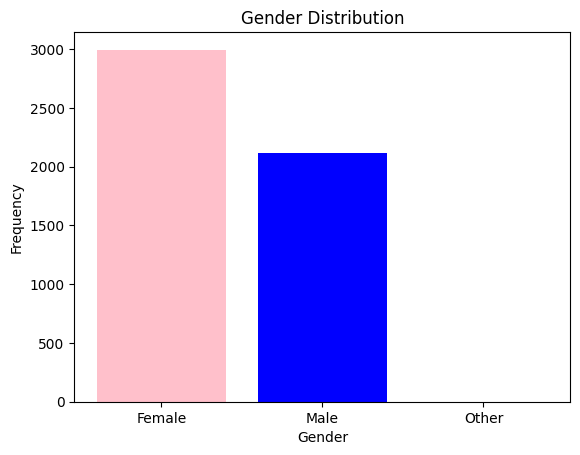

In [3]:
def see_gender_distribution(dataframe):
    plt.figure()
    plt.xlabel("Gender")
    plt.ylabel("Frequency")
    plt.title("Gender Distribution")
    plt.bar(x = dataframe['gender'].value_counts().index, height = dataframe['gender'].value_counts(), color = ['pink', 'blue', 'green'])
    dataframe['gender'].value_counts()
    
see_gender_distribution(dataframe)

#### Since there are too many missing smoke values, replacing 'Unknown' with the mode can deviate results remarkably. However, we can randomly assign "Unknown" to existing categories based on their distribution.

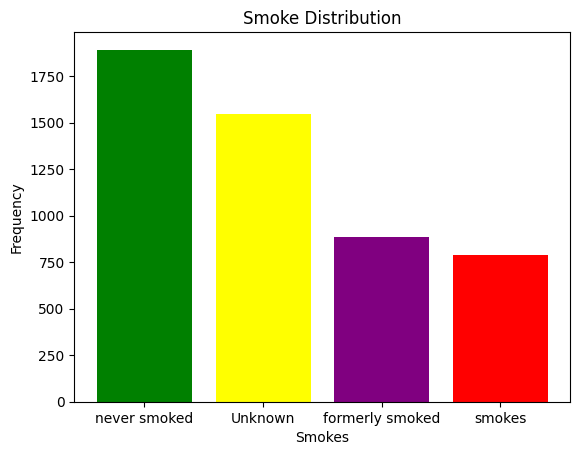

In [4]:
def see_smoke_distribution(dataframe, title = "Smoke Distribution"):
    plt.figure()
    plt.xlabel("Smokes")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.bar(x = dataframe['smoking_status'].value_counts().index, height = dataframe['smoking_status'].value_counts(), color = ['green', 'yellow', 'purple', 'red'])
    dataframe['smoking_status'].value_counts()
    
see_smoke_distribution(dataframe)

#### Since there are outliers, median imputation can be more convenient for null BMI values.

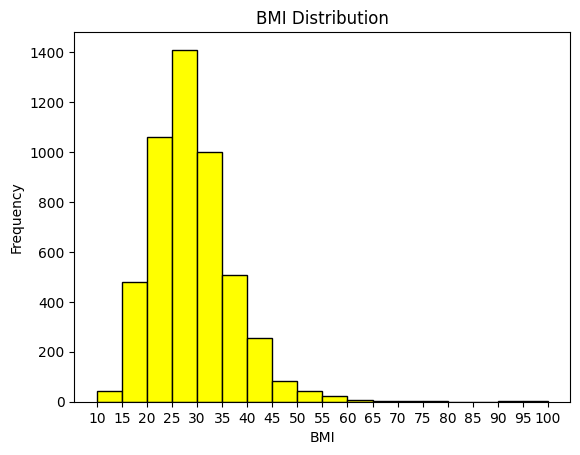

In [5]:
def see_bmi_distribution(dataframe, title = "BMI Distribution"):
    plt.figure()
    plt.xlabel("BMI")
    plt.ylabel("Frequency")
    plt.title(title)
    bins = range(int(dataframe['bmi'].min()), int(dataframe['bmi'].max()+6), 5)
    plt.hist(dataframe['bmi'], bins = bins, edgecolor='black', color = 'yellow')
    plt.xticks(bins)
    
see_bmi_distribution(dataframe)

#### Let's correct dataframe accordingly then analyze and see results.

Columns with Null Values:
There aren't any null columns.

Categorical Features and Unique Values:
  'gender': ['Male' 'Female']
  'ever_married': ['Yes' 'No']
  'work_type': ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
  'Residence_type': ['Urban' 'Rural']
  'smoking_status': ['formerly smoked' 'never smoked' 'smokes']

Numerical Columns with Negative Values:
There aren't any negative values.


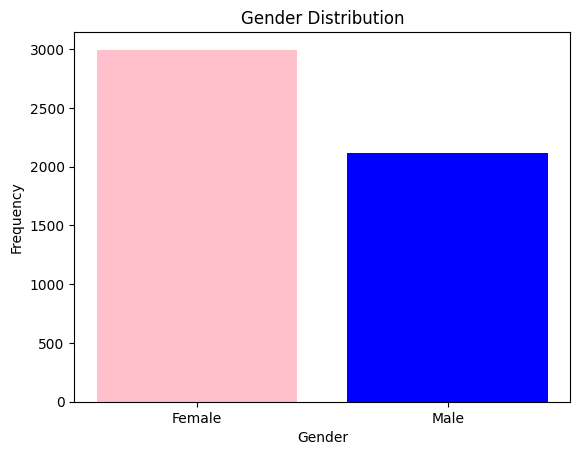

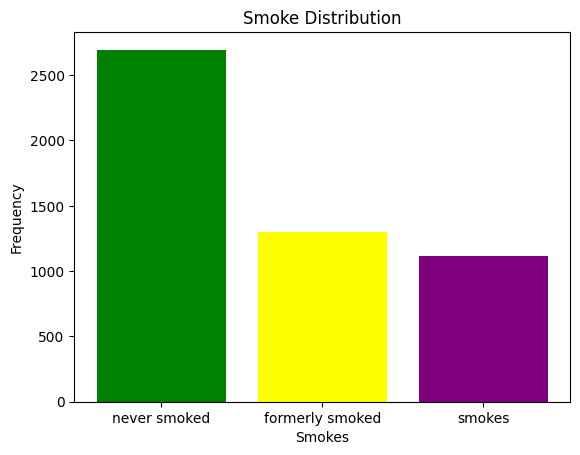

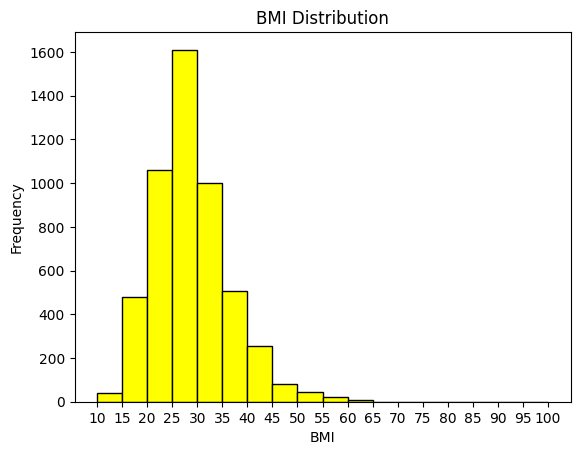

In [6]:
# Replace NaN with median
dataframe['bmi'] = dataframe['bmi'].fillna(dataframe['bmi'].median())

# Replace 'Other' value with 'Female'.
dataframe['gender'] = dataframe['gender'].replace('Other', 'Female')

probabilities = dataframe['smoking_status'][dataframe['smoking_status'] != 'Unknown'].value_counts(normalize=True)
# Replace 'Unknown' with values sampled based on probabilities
dataframe['smoking_status'] = dataframe['smoking_status'].apply(
    lambda x: np.random.choice(probabilities.index, p=probabilities.values, ) if x == 'Unknown' else x
)

see_gender_distribution(dataframe)
see_smoke_distribution(dataframe)
see_bmi_distribution(dataframe)
analyze_dataframe(dataframe)

#### Now, let's handle outliers in numerical fields, I will use median imputation according to the results of PA3.

In [7]:
def impute_outliers_with_median(data_frame, column):
    Q1 = data_frame[column].quantile(0.25)
    Q3 = data_frame[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    median = data_frame[column].median()
    
    data_frame[column] = np.where((data_frame[column] < lower_bound) | (data_frame[column] > upper_bound), median, data_frame[column])
    
impute_outliers_with_median(dataframe, 'age')    
impute_outliers_with_median(dataframe, 'bmi')
impute_outliers_with_median(dataframe, 'avg_glucose_level')

#### Encoding Types Used for Columns;
#### Label Encoding: 'gender' , 'ever_married' , 'Residence_type'
#### One-Hot Encoding: 'work_type'
#### Ordinal Encoding: 'smoking_status'

In [8]:
def do_label_encoding(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    
    print(f"Mapping of {column}:")
    for idx, class_name in enumerate(le.classes_):
        print(f"{class_name} -> {idx}")

non_encoded_df = dataframe.copy()
        
do_label_encoding(dataframe, 'gender')
do_label_encoding(dataframe, 'ever_married')
do_label_encoding(dataframe, 'Residence_type')

#One-Hot encoding
dataframe = pd.get_dummies(dataframe, columns=['work_type'], dtype='int')

#Ordinal encoding
encoding_map = {'never smoked' : 0, 'formerly smoked' : 1, 'smokes' : 2}
dataframe['smoking_status'] = dataframe['smoking_status'].map(encoding_map)
print("Mapping of smoking_status:")
for val in encoding_map.keys():
        print(f"{val} -> {encoding_map.get(val)}")


Mapping of gender:
Female -> 0
Male -> 1
Mapping of ever_married:
No -> 0
Yes -> 1
Mapping of Residence_type:
Rural -> 0
Urban -> 1
Mapping of smoking_status:
never smoked -> 0
formerly smoked -> 1
smokes -> 2


#### Data Normalization

In [9]:
numerical_columns = ['age', 'avg_glucose_level', 'bmi', 'smoking_status']
scaler = MinMaxScaler()
dataframe[numerical_columns] = scaler.fit_transform(dataframe[numerical_columns])

dataframe.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,9046,1,0.816895,0,1,1,1,0.323750,0.724928,0.5,1,0,0,1,0,0
1,51676,0,0.743652,0,0,1,0,0.323750,0.481375,0.0,1,0,0,0,1,0
2,31112,1,0.975586,0,1,1,0,0.447341,0.607450,0.0,1,0,0,1,0,0
3,60182,0,0.597168,0,0,1,1,0.323750,0.661891,1.0,1,0,0,1,0,0
4,1665,0,0.963379,1,0,1,0,0.323750,0.363897,0.0,1,0,0,0,1,0


## 1.2. Data Visualization (10 Pts)

* Visualize the distribution of numerical features
* Analyze the relationship between categorical features (e.g., gender, work_type) and the target variable (stroke).
* Plot a correlation heatmap to analyze their relationships.
* Comment on any findings

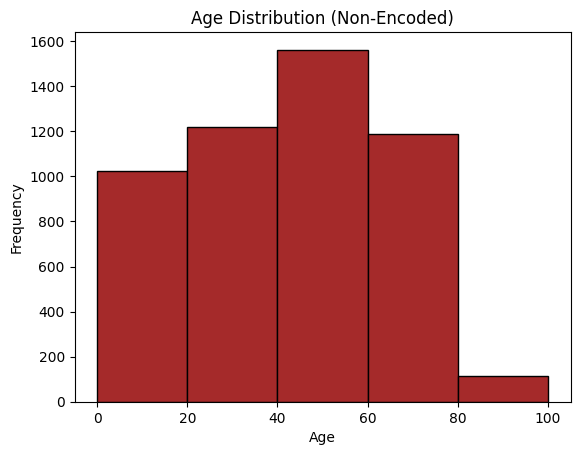

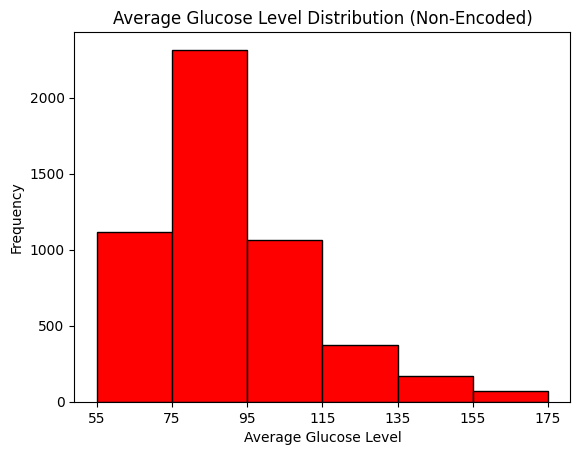

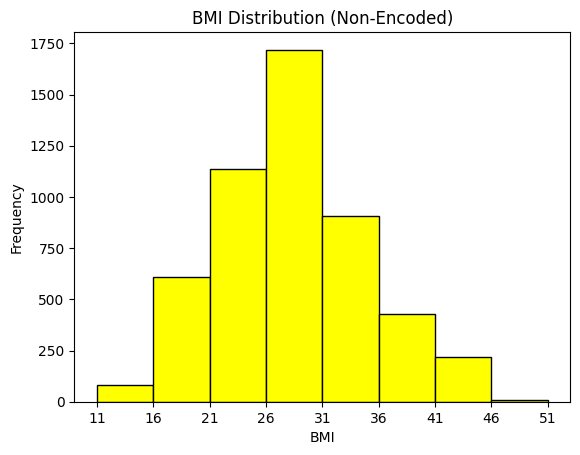

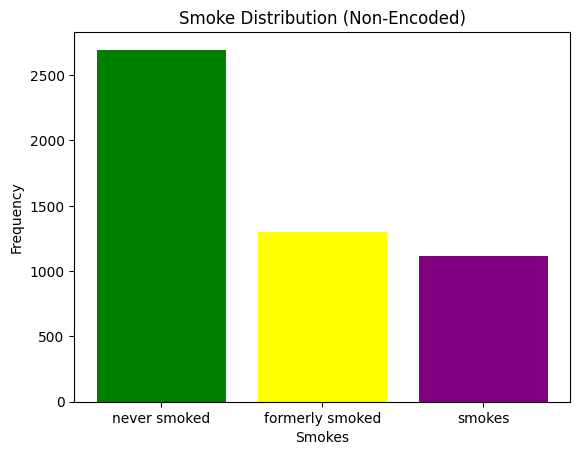

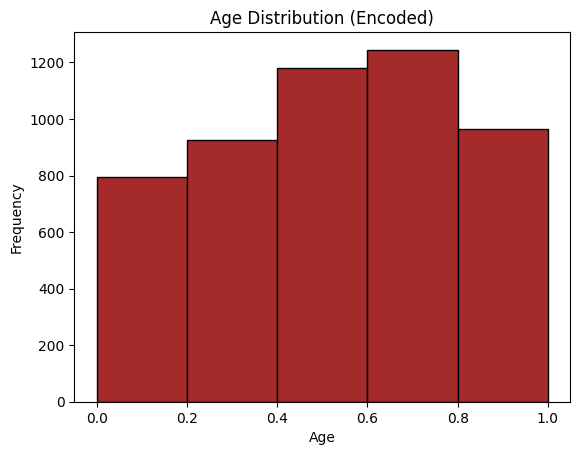

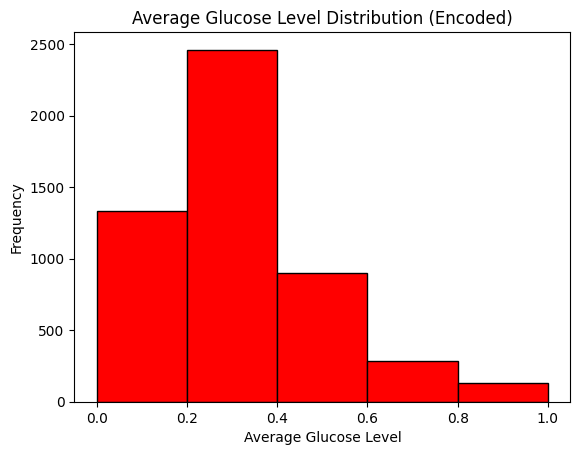

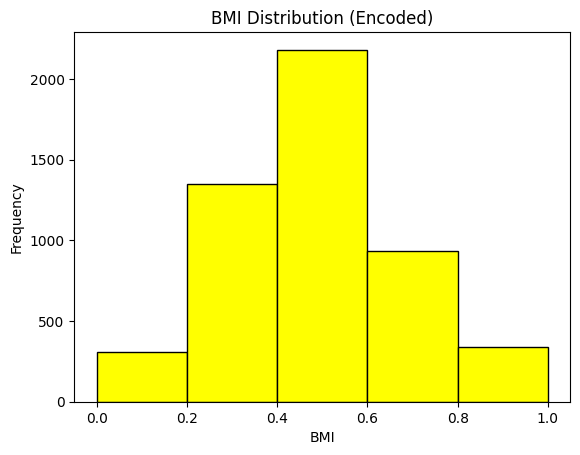

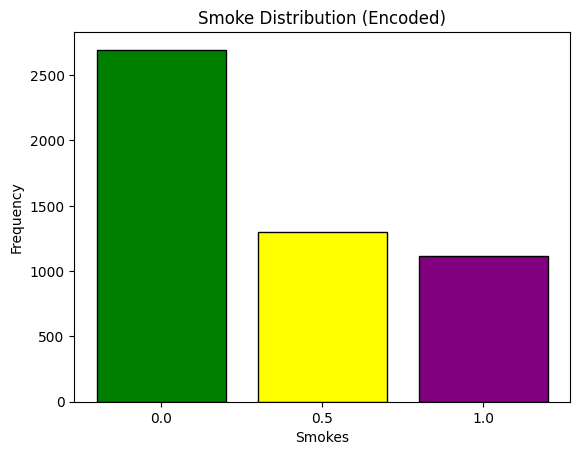

In [10]:
plt.figure()
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution (Non-Encoded)")
bins = np.arange(non_encoded_df['age'].min(), non_encoded_df['age'].max() + 21, 20)
plt.hist(non_encoded_df['age'], bins=bins, edgecolor='black', color ='brown')
plt.xticks(bins)

plt.figure()
plt.xlabel("Average Glucose Level")
plt.ylabel("Frequency")
plt.title("Average Glucose Level Distribution (Non-Encoded)")
bins = np.arange(int(non_encoded_df['avg_glucose_level'].min()), non_encoded_df['avg_glucose_level'].max() + 21, 20)
plt.hist(non_encoded_df['avg_glucose_level'], bins=bins, edgecolor='black', color ='red')
plt.xticks(bins)

see_bmi_distribution(non_encoded_df, "BMI Distribution (Non-Encoded)")
see_smoke_distribution(non_encoded_df, "Smoke Distribution (Non-Encoded)")


plt.figure()
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution (Encoded)")
bins = np.arange(dataframe['age'].min(), dataframe['age'].max() + 0.2, 0.2)
plt.hist(dataframe['age'], bins=bins, edgecolor='black', color = 'brown')
plt.xticks(bins)

plt.figure()
plt.xlabel("Average Glucose Level")
plt.ylabel("Frequency")
plt.title("Average Glucose Level Distribution (Encoded)")
bins = np.arange(dataframe['avg_glucose_level'].min(), dataframe['avg_glucose_level'].max() + 0.2, 0.2)
plt.hist(dataframe['avg_glucose_level'], bins=bins, edgecolor='black', color = 'red')
plt.xticks(bins)

plt.figure()
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("BMI Distribution (Encoded)")
bins = np.arange(dataframe['bmi'].min(), dataframe['bmi'].max() + 0.2, 0.2)
plt.hist(dataframe['bmi'], bins=bins, edgecolor='black', color = 'yellow')
plt.xticks(bins)

plt.figure()
plt.xlabel("Smokes")
plt.ylabel("Frequency")
plt.title("Smoke Distribution (Encoded)")
plt.bar(x = dataframe['smoking_status'].value_counts().index, height = dataframe['smoking_status'].value_counts(), edgecolor='black', width=0.4, color = ['green', 'yellow', 'purple', 'red'])
plt.xticks(ticks=dataframe['smoking_status'].value_counts().index)
plt.show()

#### There is no situation that seriously disrupts the stroke ratio between gender values. In other words, there is no correlation visible here.

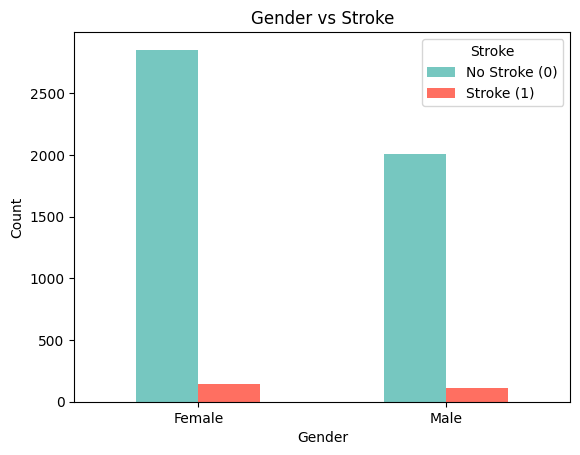

In [11]:
gender_stroke_ct = non_encoded_df.groupby('gender')['stroke'].value_counts().unstack()
gender_stroke_ct.plot(kind='bar', color=['#76c7c0', '#ff6f61'])

plt.title('Gender vs Stroke')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Stroke', labels=['No Stroke (0)', 'Stroke (1)'])
plt.show()

#### There is no situation that seriously disrupts the stroke ratio between residence values. In other words, there is no correlation visible here.

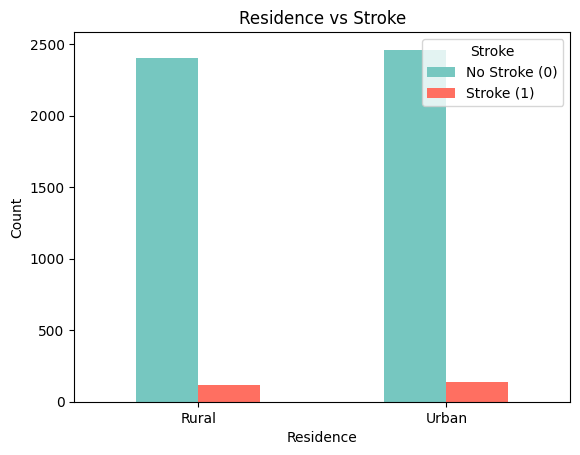

In [12]:
plt.show()
residence_stroke_ct = non_encoded_df.groupby('Residence_type')['stroke'].value_counts().unstack()
residence_stroke_ct.plot(kind='bar', color=['#76c7c0', '#ff6f61'])

plt.title('Residence vs Stroke')
plt.xlabel('Residence')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Stroke', labels=['No Stroke (0)', 'Stroke (1)'])
plt.show()

#### While the number of married people is not even twice the number of unmarried people, the number of married people who have a stroke is much more than twice the number of unmarried people who have a stroke. There can be correlation between marriage status and stroke.

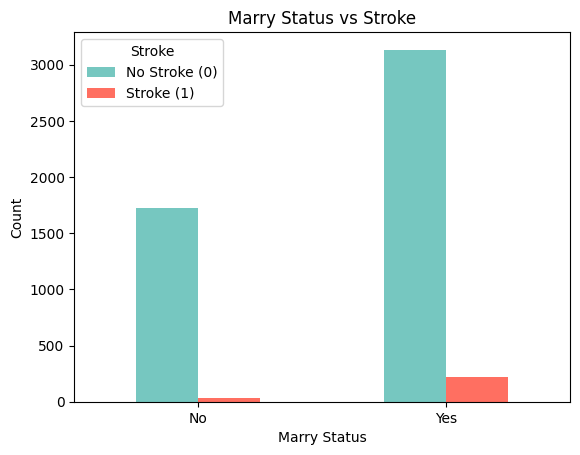

In [13]:
married_stroke_ct = non_encoded_df.groupby('ever_married')['stroke'].value_counts().unstack()
married_stroke_ct.plot(kind='bar', color=['#76c7c0', '#ff6f61'])

plt.title('Marry Status vs Stroke')
plt.xlabel('Marry Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Stroke', labels=['No Stroke (0)', 'Stroke (1)'])
plt.show()

#### There is no situation that seriously disrupts the stroke ratio between smoke values. In other words, there is no correlation visible here.

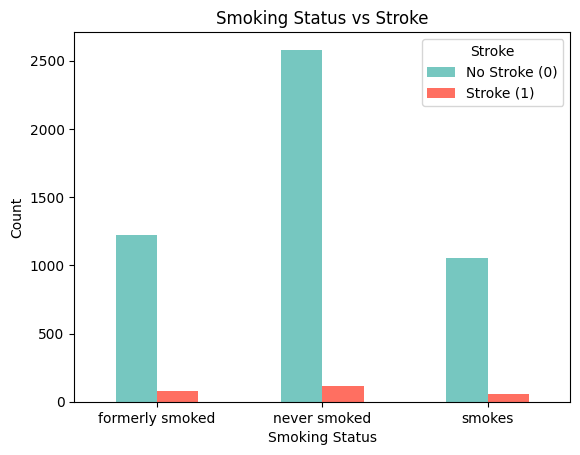

In [14]:
smoking_stroke_ct = non_encoded_df.groupby('smoking_status')['stroke'].value_counts().unstack()
smoking_stroke_ct.plot(kind='bar', color=['#76c7c0', '#ff6f61'])

plt.title('Smoking Status vs Stroke')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Stroke', labels=['No Stroke (0)', 'Stroke (1)'])
plt.show()


#### Looking at the graph, the stroke rate seems higher in private and self-employed work types.

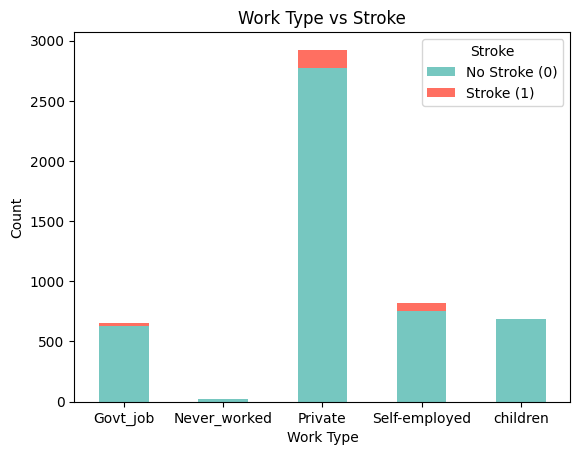

In [15]:
work_type_private_stroke_ct = non_encoded_df.groupby('work_type')['stroke'].value_counts().unstack()
work_type_private_stroke_ct.plot(kind='bar',stacked = True,  color=['#76c7c0', '#ff6f61'])

plt.title('Work Type vs Stroke')
plt.xlabel('Work Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Stroke', labels=['No Stroke (0)', 'Stroke (1)'])
plt.show()

#### Looking at the correlation heatmap, we cannot find any strong relation for stroke. 

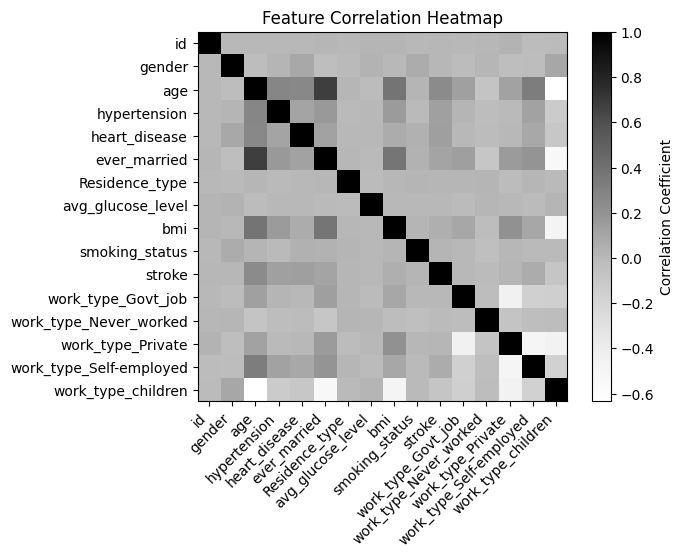

In [16]:
correlation_matrix = dataframe.corr()

plt.figure()
plt.imshow(correlation_matrix, cmap='Greys', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Feature Correlation Heatmap")

plt.show()

## 1.3. Data Splitting (5 Pts)

* Manually split the dataset into training (70%) and testing (30%) sets
* Shuffle and split the data
* Avoid using predefined functions like train_test_split for this task


In [17]:
def shuffle_df(data_frame, random_state):
    np.random.seed(random_state)
    
    shuffled_indexes = np.random.permutation(data_frame.index)
    return data_frame.loc[shuffled_indexes]
    
def test_train_split(data_frame, random_state):
    data_frame = shuffle_df(data_frame, random_state)
    test_len = int(0.3 * len(data_frame))
    test_df = data_frame[:test_len]
    train_df = data_frame[test_len:]
    return test_df, train_df

test_df, train_df = test_train_split(dataframe, 2)

In [18]:
test_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
4091,43698,0,0.328613,0,0,0,0,0.090789,0.455587,0.0,0,1,0,0,0,0
3150,69979,1,0.890137,0,0,1,0,0.323750,0.335244,1.0,0,0,0,0,1,0
2668,43039,0,0.768066,0,0,1,0,0.867207,0.478510,0.5,0,0,0,1,0,0
793,69427,0,0.353027,0,0,0,1,0.406481,0.326648,0.0,0,0,0,1,0,0
798,46683,0,0.304199,0,0,0,1,0.589028,0.449857,1.0,0,0,0,1,0,0


In [19]:
train_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
1519,18070,0,0.328613,0,0,0,0,0.157450,0.249284,0.0,0,0,0,1,0,0
2541,61252,1,0.963379,0,1,1,0,0.239081,0.481375,0.0,0,0,0,1,0,0
2533,45627,1,0.731445,0,0,1,0,0.135611,0.435530,0.5,0,0,0,1,0,0
272,4057,1,0.865723,0,0,1,1,0.323750,0.458453,0.5,0,0,0,1,0,0
3438,31701,1,0.194336,0,0,0,0,0.623195,0.286533,0.0,0,0,0,1,0,0


# **PART- 2: Model Building (30 points)**

Implement two classification models:

* k-Nearest Neighbors (kNN)
* Logistic Regression


***You can use scikit-learn***




## 2.1. kNN Classifier (15 Pts)
* Build and train the kNN model
* Choose the optimal k value using Minkowski distance with at least two different values for p


#### Id column should be dropped as it does not represent an inherent feature of record. Also we can prepare datasets for fitting. 

In [20]:
test_df.drop(columns="id", inplace=True)
train_df.drop(columns="id", inplace=True)

#### Stroke prediction is crucial in health data analysis, where we aim to identify as many cases of stroke (i.e., unhealthy individuals) as possible. While it is acceptable to mistakenly classify a healthy person as having a stroke (since doctors can perform further tests), it is critical that we never miss diagnosing an unhealthy individual. In this context, recall is far more important than accuracy. To illustrate this, I will compare two models: one with (k=1, p=1)(has best recall and close to the best accuracy) and another with (k=5, p=2)(best on average).

k=1, p=1, Accuracy=0.92368, Recall=0.12000
k=2, p=1, Accuracy=0.94586, Recall=0.01333
k=3, p=1, Accuracy=0.93868, Recall=0.01333
k=4, p=1, Accuracy=0.94977, Recall=0.01333
k=5, p=1, Accuracy=0.94716, Recall=0.02667
k=6, p=1, Accuracy=0.95108, Recall=0.01333
k=7, p=1, Accuracy=0.94977, Recall=0.01333
k=8, p=1, Accuracy=0.95108, Recall=0.00000
k=9, p=1, Accuracy=0.95108, Recall=0.00000
k=10, p=1, Accuracy=0.95108, Recall=0.00000
k=11, p=1, Accuracy=0.95108, Recall=0.00000
k=12, p=1, Accuracy=0.95108, Recall=0.00000
k=13, p=1, Accuracy=0.95108, Recall=0.00000
k=14, p=1, Accuracy=0.95108, Recall=0.00000
k=15, p=1, Accuracy=0.95108, Recall=0.00000
k=16, p=1, Accuracy=0.95108, Recall=0.00000
k=17, p=1, Accuracy=0.95108, Recall=0.00000
k=18, p=1, Accuracy=0.95108, Recall=0.00000
k=19, p=1, Accuracy=0.95108, Recall=0.00000
k=1, p=2, Accuracy=0.91650, Recall=0.09333
k=2, p=2, Accuracy=0.94586, Recall=0.01333
k=3, p=2, Accuracy=0.93933, Recall=0.02667
k=4, p=2, Accuracy=0.95108, Recall=0.01333
k

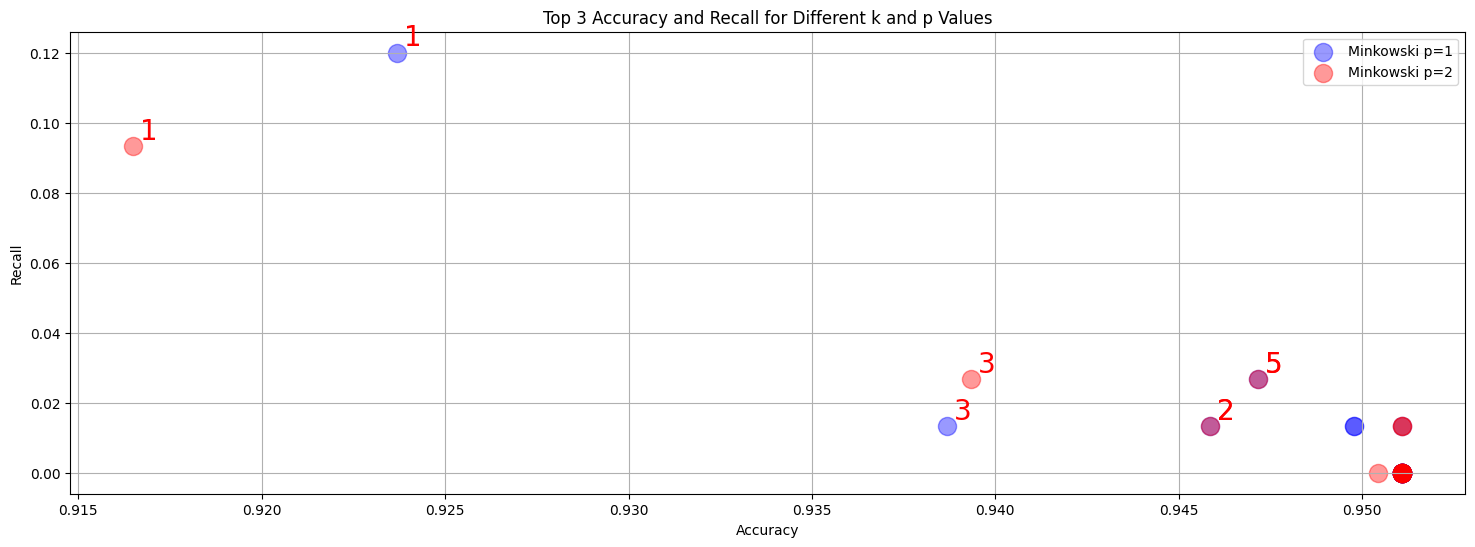

In [21]:
def apply_kNN_regression(X_test, y_test, X_train, y_train, k_range=range(1, 20), p_range=(1,2)):    
    results = {}
    results_recall = {}
    selected_predictions = {}
    y_prob_knn = 0
    for p in p_range:
        accuracies = []
        recalls = []
        for k in k_range:
            knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=p)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred, zero_division=0)
            accuracies.append(accuracy)
            recalls.append(recall)
            print(f"k={k}, p={p}, Accuracy={accuracy:.5f}, Recall={recall:.5f}")
            
            if (k == 1 and p == 1) or (k == 5 and p ==2):
                selected_predictions[p] = y_pred
                y_prob_knn = knn.predict_proba(X_test)[:, 1]
                
        results[p] = accuracies
        results_recall[p] = recalls
        
    plot_accuracy_vs_recall(results, results_recall, k_range)
    
    return selected_predictions, y_prob_knn
    

def prepare_data(data_frame):
    X = data_frame.drop("stroke", axis=1)  # Features
    y = data_frame["stroke"]  # Target variable
    return X, y


import numpy as np

def plot_accuracy_vs_recall(results_accuracy, results_recall, k_range=range(1, 20)):
    plt.figure(figsize=(18, 6))
    
    for p in results_accuracy.keys():
        color = "blue" if (p == 1) else "red"
        accuracies = results_accuracy[p]
        recalls = results_recall[p]
        plt.scatter(accuracies, recalls, label=f'Minkowski p={p}', alpha=0.4, s=170, color=color)
        
        top_recall_indices = np.argsort(recalls)[-4:]      # Indices of top 3 recalls

        for idx in top_recall_indices:
            k = k_range[idx]
            plt.annotate(str(k), 
                         (accuracies[idx], recalls[idx]), 
                         fontsize=20, 
                         alpha=1, 
                         xytext=(5, 5),  
                         textcoords='offset points', 
                         color='red')
    
    plt.xlabel('Accuracy')
    plt.ylabel('Recall')
    plt.title('Top 3 Accuracy and Recall for Different k and p Values')
    plt.legend()
    plt.grid(True)
    plt.show()




    
X_test, y_test = prepare_data(test_df)
X_train, y_train = prepare_data(train_df)
selected_predictions, y_prob_knn = apply_kNN_regression(X_test, y_test, X_train, y_train)


## 2.2. Logistic Regression (15 Pts)
* Build and train the Logistic Regression model

#### The dataset is highly imbalanced, with many more 0 (healthy) cases than 1 (unhealthy) cases. To address this, I used class_weight='balanced' in logistic regression to give more importance to correctly predicting the minority class (1), which improves recall. Since recall is more important than accuracy in this context—ensuring that we don’t miss diagnosing unhealthy individuals—this adjustment helps avoid missing stroke cases. Accuracy alone would be misleading, as it might be high due to predicting the majority class.

In [22]:
def apply_logistic_regression(X_test, y_test, X_train, y_train):

    log_reg = LogisticRegression(random_state=212, class_weight="balanced")
    log_reg.fit(X_train, y_train)
    
    y_pred = log_reg.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Logistic Regression Accuracy: {accuracy:.5f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    y_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]

    return y_pred, y_prob_log_reg
    
    
y_pred_logistic, y_prob_log_reg = apply_logistic_regression(X_test, y_test, X_train, y_train)

Logistic Regression Accuracy: 0.72603

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1458
           1       0.13      0.81      0.23        75

    accuracy                           0.73      1533
   macro avg       0.56      0.77      0.53      1533
weighted avg       0.94      0.73      0.80      1533


Confusion Matrix:
[[1052  406]
 [  14   61]]



# **PART- 3: Model Evaluation (35 points)**



## 3.1 Confusion Matrix (15)

Analysis of the confusion matrices for both models:

* Plot and interpret the confusion matrices
* Display accuracy, precision, recall, and F1-score for both models



#### In kNN classifiers majority of the predictions are majority class which is 0 and this makes their accuracy high. However, even for the selected best k and p values, they cannot be used since they are terrible at diagnosing. They couldn't predict most of the strokes. In logistic regression, recall is remarkably better which makes it utilizable, but it diagnoses stroke for healthy individuals pretty frequently which can cost time and money waste. Trying to find a better threshold value might be ideal.  

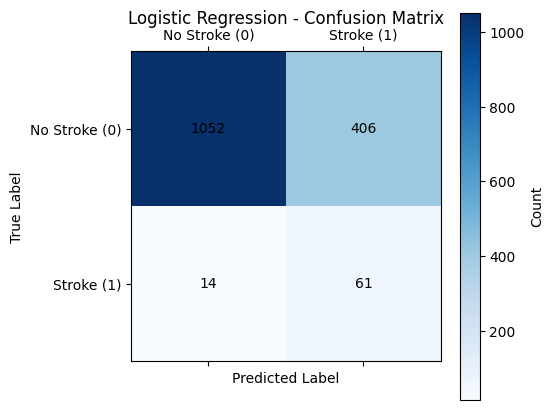

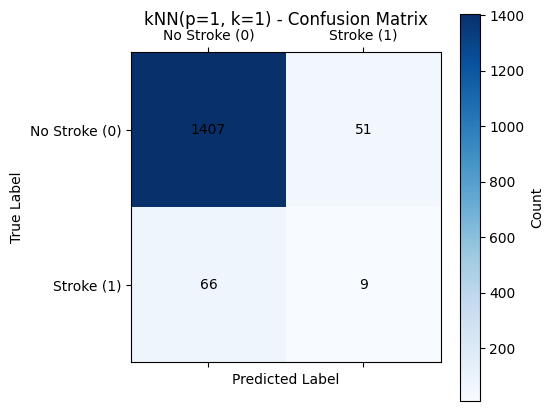

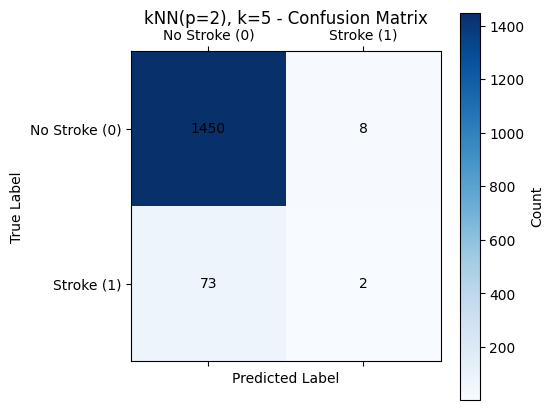

In [23]:
# Function to plot confusion matrix
def plot_conf_matrix(y_test, y_pred, model_name="Model"):
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5, 5))
    plt.matshow(cm, cmap='Blues', fignum=1)  # Using a gray colormap for simplicity
    plt.title(f'{model_name} - Confusion Matrix', pad=20)
    plt.colorbar(label="Count")
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color="black")
    
    tick_marks = range(len(cm))
    plt.xticks(tick_marks, ['No Stroke (0)', 'Stroke (1)'])
    plt.yticks(tick_marks, ['No Stroke (0)', 'Stroke (1)'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_conf_matrix(y_test, y_pred_logistic, model_name="Logistic Regression")

plot_conf_matrix(y_test, selected_predictions.get(1), model_name="kNN(p=1, k=1)")

plot_conf_matrix(y_test, selected_predictions.get(2), model_name="kNN(p=2), k=5")

In [24]:
# Function to display classification metrics
def display_metrics(y_test, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Precision: {precision:.5f}")
    print(f"Recall: {recall:.5f}")
    print(f"F1-Score: {f1:.5f}")
    
    return accuracy, precision, recall, f1

display_metrics(y_test, y_pred_logistic, model_name="Logistic Regression")

display_metrics(y_test, selected_predictions.get(1), model_name="kNN(p=1, k=1)")
display_metrics(y_test, selected_predictions.get(2), model_name="kNN(p=2, k=5)")


Logistic Regression Performance Metrics:
Accuracy: 0.72603
Precision: 0.13062
Recall: 0.81333
F1-Score: 0.22509

kNN(p=1, k=1) Performance Metrics:
Accuracy: 0.92368
Precision: 0.15000
Recall: 0.12000
F1-Score: 0.13333

kNN(p=2, k=5) Performance Metrics:
Accuracy: 0.94716
Precision: 0.20000
Recall: 0.02667
F1-Score: 0.04706


(0.9471624266144814,
 np.float64(0.2),
 np.float64(0.02666666666666667),
 np.float64(0.047058823529411764))

## 3.2 Precision-Recall Curves (5)

Evaluate the Precision-Recall curves for both models:

* Plot and analyze the curves

#### The plot reveals that KNN excels at high precision, but struggles with recall, especially for the minority class (1s). This means KNN is good at identifying true positives but might miss many actual positives. Logistic Regression, while not as precise as KNN, offers a better balance between precision and recall, making it potentially more suitable for health predictions where both false positives and false negatives are important to minimize.

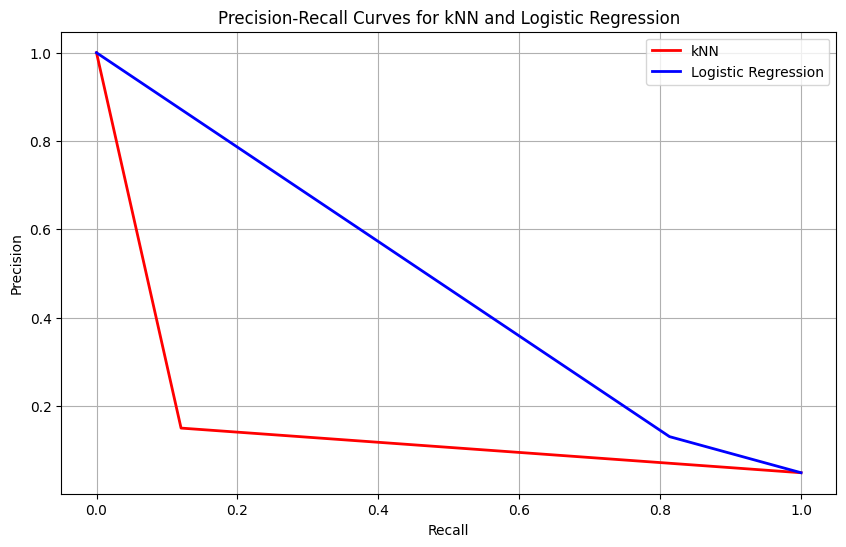

In [25]:
precision_knn, recall_knn, _ = precision_recall_curve(y_test, selected_predictions[1])

precision_log, recall_log, _ = precision_recall_curve(y_test, y_pred_logistic)

plt.figure(figsize=(10, 6))
plt.plot(recall_knn, precision_knn, label='kNN', color='red', linewidth=2)
plt.plot(recall_log, precision_log, label='Logistic Regression', color='blue', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for kNN and Logistic Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 3.3. Compare the Model (15 Pts)

Prepare a detailed evaluation report with metrics, visualizations, and comparative analysis.

* Compare the performance of kNN and Logistic Regression based on the metrics.

* Discuss which model performs better and hypothesize why.

#### Logistic Regression performed better than kNN on the imbalanced dataset because of several factors. First, Logistic Regression uses class_weight='balanced', which adjusts the model to give more importance to the minority class (strokes). This improves recall for the minority class, ensuring more strokes are detected. In contrast, kNN is biased toward the majority class (healthy individuals) due to the proximity of neighbors, making it less effective at identifying strokes. Logistic Regression also provides probabilities for classification, allowing for threshold adjustments to prioritize recall, while kNN relies on majority voting from neighbors, which doesn't allow for threshold tuning. Logistic Regression’s ability to adjust the decision boundary and learn from data helps it handle imbalances better. kNN can struggle with high-dimensional data because the concept of "nearest neighbor" becomes less meaningful, leading to poor performance. Overall, Logistic Regression's flexibility and class weighting made it better suited for this task, especially in terms of recall.

#### Also we should have done cross validation especially for kNN to be sure that characteristics of data is represented in training set as randomness of split and skewed data can cause there aren't enough stroke record to characterize and fit the model. In these situations under-fit can occur. 

#### In order to avoid under-fit coming from the skewed nature of the dependent variable, we might additionally apply SMOTE technique and create artificial data points of the minority class. 

#### **Accuracy Comparison**
- **kNN(p=2, k=5)** shows the highest accuracy (94.72%), followed by **kNN(p=1, k=1)** with 92.37%, and **Logistic Regression** with 72.60%.
- However, **accuracy** alone is not sufficient to evaluate model performance, especially in imbalanced datasets like stroke prediction, where the majority class (healthy individuals) dominates.

#### **Precision Comparison**
- **kNN(p=2, k=5)** achieves the highest precision (0.200), followed by **kNN(p=1, k=1)** with 0.150, and **Logistic Regression** with 0.130.
- Despite higher accuracy and precision, **kNN** models struggle with **recall**, as they are primarily predicting the majority class.

#### **Recall Comparison**
- **Logistic Regression** significantly outperforms both kNN models in recall (0.813), showing it is much better at identifying the minority class (strokes). Recall is critical in medical scenarios to ensure that strokes are not missed.
- In contrast, **kNN(p=1, k=1)** and **kNN(p=2, k=5)** have much lower recall, with **kNN(p=1, k=1)** at 0.120 and **kNN(p=2, k=5)** at 0.027. This shows that kNN fails to detect most of the strokes, making it unsuitable for this type of task.

#### **F1-Score Comparison**
- **Logistic Regression** has a higher F1-Score (0.225) compared to **kNN(p=1, k=1)** (0.133) and **kNN(p=2, k=5)** (0.047).
- The F1-Score balances precision and recall, and **Logistic Regression**'s higher score further supports its better overall performance, particularly in recall.

### Hypothesis

1. **Class Imbalance Handling**:
   - **Logistic Regression** benefits from the `class_weight='balanced'` parameter, which adjusts the model to focus more on the minority class (strokes). This helps improve recall, making it more effective at detecting strokes even though it might predict some false positives (healthy individuals).
   - **kNN**, on the other hand, struggles with imbalanced datasets. It tends to predict the majority class (healthy individuals) due to the influence of nearest neighbors, resulting in poor recall for the minority class (strokes).

2. **Model Selection**:
   - **Logistic Regression** is a linear model that can learn a decision boundary and adjust its threshold to prioritize recall. It performs well on imbalanced data by giving more weight to the minority class.
   - **kNN** is a non-parametric algorithm that depends on the distance to nearest neighbors. In imbalanced datasets, this leads to a bias toward the majority class and poor performance on the minority class, as seen in the low recall values.

3. **Threshold Adjustment**:
   - **Logistic Regression** provides probabilities, which allow for flexible decision threshold adjustments to prioritize recall (catching as many true positives as possible).
   - **kNN** does not offer such flexibility and instead relies solely on the majority vote from neighbors, which results in poor stroke detection.

### Conclusion

- **Logistic Regression** is the better model for this dataset, especially in terms of **recall**. Its ability to handle class imbalance, adjust decision thresholds, and focus on the minority class (strokes) makes it the most suitable for stroke prediction.
- **kNN**'s high accuracy and precision are misleading, as it fails to identify most strokes. It’s more biased toward predicting the majority class, which makes it ineffective for this task.
- Therefore, **Logistic Regression** should be preferred, as recall is critical in medical applications where missing a stroke diagnosis can have severe consequences.

#### The ROC curve for Logistic Regression resembles more the ideal curve, indicating that the model performs better in distinguishing between the positive and negative classes. Additionally, the area under the curve (AUC) for Logistic Regression is higher, suggesting that the model has a better overall fit and is more capable of correctly identifying the stroke (positive class) compared to the other models. This behavior aligns with the higher recall observed for Logistic Regression, making it more suitable for tasks where detecting the positive class is crucial.

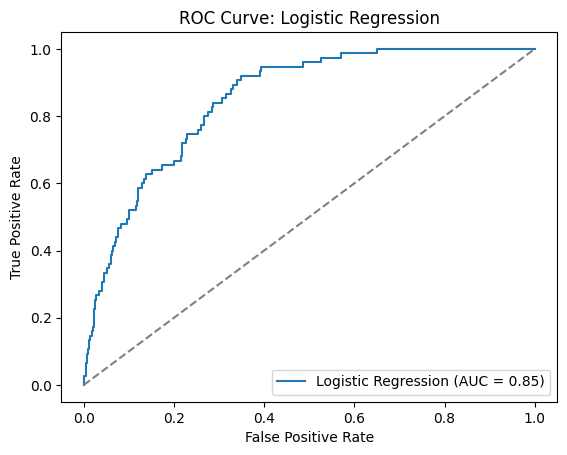

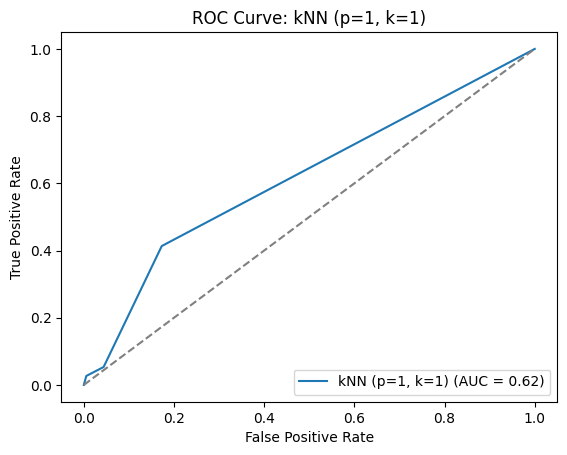

In [26]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Logistic Regression ROC
plot_roc_curve(y_test, y_prob_log_reg, 'Logistic Regression')

# kNN ROC (p=1, k=1)
plot_roc_curve(y_test, y_prob_knn, 'kNN (p=1, k=1)')


# SUBMIT FORMAT

* **<-zip>**
  - **studentID_name_surname_hw4.ipynb**


# PLAGIARISM

All work on assignments must be done individually. You are encouraged to discuss the given assignments with your classmates, but these discussions should be carried out in an abstract way. That is, discussions related to a particular solution to a specific probem (either in actual code or in pseudocode) will not be tolerated. In short, turning in someone else’s work (including work available on the internet), in whole or in part, as your own will be considered as a violation of academic integrity. Please note that the former conditions also hold for the material attained using AI tools, including ChatGPT, GitHub Copilot, etc.